In [3]:
import random
import os
import time
import warnings
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchtext import data
from torchtext import datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from model_LSTM import RNN

# Data directory for saving
from data_dir import data_dir as model_dir
# Directory for datasets and pretrained word vectors
datasets_dir = os.path.join(model_dir, 'sentiment_analysis/data')

In [3]:
# Parameters
# TSM: Tai, Socher, Manning, 2015 for SST-2
# Choose dataset
DATASET = ['SST', 'IMDB'][0]
# Choose pretrained embedding? (GloVe)
PRETRAINED_EMB = True       # TSM: T
# Scale pretrained embedding by 1/sqrt(N)
SCALE_EMB = False
# Train the embedding?
TRAIN_EMB = False           # TSM: T

# Data set and training parameters
if DATASET == 'SST':
    MAX_VOCAB_SIZE = None   # max: 15431; TSM: None
    N_LAYERS = 2            # TSM: 1, 2

    RNN_TYPE = 'LSTM'       # TSM: LSTM
    BATCH_SIZE = 64         # TSM: 25 (paper) or 5 (github repo)
    EMB_DIM = [50, 100, 200, 300][1] # TSM: 300
    HIDDEN_DIM = 256       # TSM: 150
    G_REC = None
    N_EPOCHS = 500
    DROPOUT = 0.5

    # RNN_TYPE = 'RNN'
    # BATCH_SIZE = 64
    # EMB_DIM = [50, 100, 200, 300][1] 
    # HIDDEN_DIM = 1024
    # G_REC = None
    # N_EPOCHS = 200
    # DROPOUT = 0.0 

elif DATASET == 'IMDB':
    MAX_VOCAB_SIZE = 25_000 # for IMDB
    BATCH_SIZE = 64
    HIDDEN_DIM = 1024
    N_LAYERS = 2
    RNN_TYPE = 'LSTM'
    N_EPOCHS = 500
    EMB_DIM = [50, 100, 200, 300][3]
    G_REC = None
    DROPOUT = 0.2           # TSM: 0.5
# Network parameters
BIDIRECTIONAL = False       # TSM: F, T
WEIGHT_DECAY = 0            # TSM: 0

# Initial weight statistics from previous training?
LOAD_WB_STAT = False

# Use binary or multiple labels? 
# Use multiple for SST with neutral labels or SST-5: fine-grained sentiments).
BINARY_LABELS = True

# Random seed
SEED = random.randint(0, 9999)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

###########################################################################
# File name for saved model (model.pt)
if G_REC is not None:
    g_str = ''.join(('_g_%.1f'%G_REC).split('.'))
# Embedding
emb_str = '_emb'
if PRETRAINED_EMB:
    emb_str += "_pretrained"
else:
    emb_str += "_random"
if SCALE_EMB:
    emb_str += "_scaled"
if TRAIN_EMB:
    emb_str += "_train"
else:
    emb_str += "_fix"
emb_str += '_dim_%d'%EMB_DIM
# Regularization
dropout_str = ''.join(('_dropout_%.1f'%DROPOUT).split('.'))
weight_decay_str = ''.join(('_weight_decay_%.3f'%WEIGHT_DECAY).split('.'))
# Join
model_name = (DATASET.lower() 
              + ('_nvocab_' + str(MAX_VOCAB_SIZE) 
                 if MAX_VOCAB_SIZE is not None else '')
              + '_' + RNN_TYPE.lower()
              + '_nlayers_%d'%N_LAYERS 
              + '_nhid_%d'%HIDDEN_DIM 
              + (g_str if G_REC is not None else '')
              + emb_str
              + dropout_str
              + weight_decay_str
              + '_seed_%d'%SEED)
model_name += '.pt'
SAVE = os.path.join(model_dir, model_name)
print("Will save model to \n  '%s'" % SAVE)

Will save model to 
  '../../../data/nlp/sentiment_analysis/saved_models\sst_lstm_nlayers_2_nhid_256_emb_pretrained_fix_dim_100_dropout_05_weight_decay_0000_seed_4724.pt'


In [4]:
# Define how the dataset is split. 
# Tokenize = act of splitting the string into discrete 'tokens'.
# Include length for packed padded sequences
TEXT = data.Field(tokenize ='spacy', include_lengths=True)
if BINARY_LABELS:
    LABEL = data.LabelField(dtype=torch.float)
else:
    LABEL = data.LabelField()

# Load dataset (downloads first if not provided).
if DATASET == 'SST':
    train_data, valid_data, test_data = datasets.SST.splits(TEXT, LABEL, 
        root=datasets_dir, fine_grained=False, filter_pred=lambda ex: ex.label != 'neutral')
elif DATASET == 'IMDB':
    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root=datasets_dir)
    print('   Loading dataset complete.')
    # Split train into train and validation set
    train_data, valid_data = train_data.split(random_state=random.seed(SEED))
else:
    raise NotImplementedError()

# Understand the dataset
print(f'\nNumber of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# Total number of words in the entire dataset (counting doubles)
n_total_words = 0
for ex in train_data.examples:
    n_total_words += len(ex.text)
print(f'\nTotal number of words in training dataset: {n_total_words:,}')
print("Average sentence length: %.1f words." % (n_total_words / len(train_data)))

# One example sentence
ex = train_data.examples[0].text
print("\nExample sentence (len = %d):" % len(ex))
print(' '.join(ex))

C:\Users\frsch\anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\frsch\anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading trainDevTestTrees_PTB.zip


datasets\sst\trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:02<00:00, 274kB/s]  
C:\Users\frsch\anaconda3\lib\site-packages\torchtext\data\example.py:94: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


extracting


C:\Users\frsch\anaconda3\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
C:\Users\frsch\anaconda3\lib\site-packages\torchtext\data\example.py:94: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)



Number of training examples: 6920
Number of validation examples: 872
Number of testing examples: 1821

Total number of words in training dataset: 138,260
Average sentence length: 20.0 words.

Example sentence (len = 39):
The Rock is destined to be the 21st Century 's new ` ` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean - Claud Van Damme or Steven Segal .


In [4]:
# Build a vocabulary from training data. 
# Limit the max size of vocabulary (otherwise > 100,000).

# # Randomly initialized:
if PRETRAINED_EMB:
    # Pretrained word embeddings (~1 GB to download!)
    TEXT.build_vocab(train_data, 
                     max_size=MAX_VOCAB_SIZE, 
                     vectors="glove.6B.%dd"%EMB_DIM, 
                     vectors_cache=datasets_dir,
                     unk_init=torch.Tensor.normal_)
else:
    TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)

LABEL.build_vocab(train_data)

# Create iterators over datasets
# The BucketIterator will return batches with examples of similar lengths to minimize padding. 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device)

# For the vocabulary, note that there are 2 extra tokens, for <unk> and <pad>.
print(f"Full length of vocab without capping at "
      + f"MAX_VOCAB_SIZE: {len(TEXT.vocab.freqs.most_common()):,}")
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab):,}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab):,}")
print("LABELS:", LABEL.vocab.stoi)

assert BINARY_LABELS == (len(LABEL.vocab.stoi) == 2), '\n\nLabels are not binary!\n'

# Print most and least common words
n_show = 10
print("\nFirst %d words of entire vocab:"%n_show)
print(np.array(TEXT.vocab.freqs.most_common(n_show)))
n_show = 5
print("\nLast %d words included in the vocab:"%n_show)
print(np.array(TEXT.vocab.freqs.most_common(MAX_VOCAB_SIZE)[-n_show:]))
print("\nLast %d words of entire vocab:"%n_show)
print(np.array(TEXT.vocab.freqs.most_common()[-n_show:]))

100%|█████████▉| 399999/400000 [00:26<00:00, 15211.16it/s]


Full length of vocab without capping at MAX_VOCAB_SIZE: 101,626
Unique tokens in TEXT vocabulary: 25,002
Unique tokens in LABEL vocabulary: 2
LABELS: defaultdict(None, {'pos': 0, 'neg': 1})

First 10 words of entire vocab:
[['the' '202928']
 [',' '192692']
 ['.' '166088']
 ['and' '109604']
 ['a' '108799']
 ['of' '100715']
 ['to' '93410']
 ['is' '76641']
 ['in' '61096']
 ['I' '54128']]

Last 5 words included in the vocab:
[['TRULY' '6']
 ['CAUSE' '6']
 ['warmer' '6']
 ['Thirty' '6']
 ['proclaiming' '6']]

Last 5 words of entire vocab:
[['straddled' '1']
 ['generated.<br' '1']
 ['/>"Kinjite' '1']
 ['implied).<br' '1']
 ['Mechanic' '1']]


/home/fs/gpu_ml_env/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [5]:
# Create RNN instance
INPUT_DIM = len(TEXT.vocab)
if BINARY_LABELS:
    OUTPUT_DIM = 1
else:
    OUTPUT_DIM = len(LABEL.vocab)
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Instantiate
model = RNN(RNN_TYPE, INPUT_DIM, EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
            BIDIRECTIONAL, DROPOUT, PAD_IDX, TRAIN_EMB)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nThe model has {count_parameters(model):,} trainable parameters')

# Embedding
if PRETRAINED_EMB:
    # Apply pretrained embeddings
    pretrained_embeddings = TEXT.vocab.vectors
    model.encoder.weight.data.copy_(pretrained_embeddings)
if SCALE_EMB:
    model.encoder.weight.data *= 1 / np.sqrt(HIDDEN_DIM)
# Initialize <unk> and <pad> to zero:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.encoder.weight.data[UNK_IDX] = torch.zeros(EMB_DIM)
model.encoder.weight.data[PAD_IDX] = torch.zeros(EMB_DIM)
# print(model.embedding.weight.data)

# RNN and decoder
if LOAD_WB_STAT:
    # Choose file
    wb_stat_name = 'sst_emb_pretrained_scaled_fix_dim_300_lstm_nlayers_1_nhid_150_dropout_05_seed_1234'
    # Load and set weights
    wb_stat_file = os.path.join(model_dir, wb_stat_name)
    with open(args.wb_stat_file, 'rb') as f:
        wb_stat = pickle.load(f)  
    for key, param in model.named_parameters():
        if 'encoder' in key:
            # Leave as is!
            pass 
        elif 'rnn' in key:
            # RNN weights and biases come in blocks of n_rnn * N x N. Separate these blocks.
            for k, key_rnn in enumerate(model.keys_rnn):
                wb_mean, wb_std = wb_stat[key][key_rnn]
                mul = param.shape[0] // model.n_rnn
                sub_w = param[k*mul : (k+1)*mul]
                sub_w.data.normal_(wb_mean, wb_std)
                print(key, key_rnn, ' ', wb_mean, wb_std)
        elif 'decoder' in key:
            wb_mean, wb_std = wb_stat[key]
            param.data.normal_(wb_mean, wb_std)
            print(key, ' ', wb_mean, wb_std)
elif G_REC is not None:
    # Recurrent weights
    for key, param in model.rnn.named_parameters():
        if 'weight' in key:
            # Input vs. recurrent
            hh_or_ih, layer_str = key.split('_')[1:]
            layer = int(layer_str[1:])
            # Input layer: scale by 1/sqrt(embedding_dim)
            print(hh_or_ih, layer)
            if hh_or_ih == 'ih' and layer == 0:
                param.data.normal_(0, 1. / np.sqrt(model.embedding_dim))
            else:
                # LSTM and GRU cells have combined weights for the effect of the
                # last hidden state on the new state and the gates. 
                # We scale only the hidden-to-hidden weights ('hh') by
                # a factor g controlling the radius of the spectrum.
                for k, key_rnn in enumerate(model.keys_rnn):
                    mul = param.shape[0] // model.n_states
                    sub_w = param[k*mul : (k+1)*mul]
                    if hh_or_ih == 'hh' and key_rnn == 'c':
                        # Scale only the recurrent state weights by g
                        sub_w.data.normal_(0, G_REC / np.sqrt(model.hidden_dim))
                    else:
                        sub_w.data.normal_(0, 1. / np.sqrt(model.hidden_dim))
        else:
            # Biases are set to zero by default. 
            pass
            
        # # Decoder: leave as is...
        # decoder_max = math.sqrt(3 / model.hidden_dim)
        # model.decoder.weight.data.uniform_(-decoder_max, decoder_max)
        # model.decoder.bias.data.zero_()
else:
    # Use standard initialization, but rescale the input weights of layer 0. 
    # model.rnn.weight_ih_l0.data.uniform_(0, 1. / np.sqrt(model.embedding_dim))
    a = 1. / np.sqrt(model.embedding_dim)
    model.rnn.weight_ih_l0.data.uniform_(-a, a)

# Save the initial model connectivity
state_dict_init = copy.deepcopy(model.state_dict())

# Move model to GPU before choosing the optimizer
model = model.to(device)



The model has 13,829,121 trainable parameters


In [6]:
# Training
import torch.optim as optim
import torch.nn as nn

# Choose optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
# optimizer = optim.Adagrad(model.parameters(), lr=0.05)
# optimizer = optim.Adam(model.parameters())

# Learning rate for adam should be scaled by network size!
lr0 = 0.01
lr = lr0 / HIDDEN_DIM
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

if BINARY_LABELS:
    # Binary cross-entropy loss with logits
    criterion = nn.BCEWithLogitsLoss().to(device)
    # Binary accuracy
    def accuracy(preds, y):
        #round predictions to the closest integer
        rounded_preds = torch.round(torch.sigmoid(preds))
        correct = (rounded_preds == y).float() #convert into float for division 
        acc = correct.sum() / len(correct)
        return acc
else:
    # Cross-entropy loss
    criterion = nn.CrossEntropyLoss().to(device)
    # Categorical accuracy
    def accuracy(preds, y):
        """ Categorical accuracy for multiple classes."""
        max_preds = preds.argmax(dim=1, keepdim=True) # get the index of the max probability
        correct = max_preds.squeeze(1).eq(y)
        return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc = accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Run training
best_valid_loss = float('inf')
train_losses, valid_losses = np.zeros((2, N_EPOCHS))
loss_acc = np.zeros((N_EPOCHS, 4))
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Save losses and accuracy
    loss_acc[epoch] = train_loss, valid_loss, train_acc, valid_acc

    # # Save the best model so far
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     state_dict_best = copy.deepcopy(model.state_dict())
    
    show_step = N_EPOCHS // 20
    if (epoch + 1) % show_step == 0 or epoch == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        # Save
        state_dict_final = model.state_dict()
        with open(SAVE, 'wb') as f:
            torch.save({'state_dict_init': state_dict_init,
                        'state_dict_final': state_dict_final,
                        'loss_acc': loss_acc,
                        }, f)


#######################################################################        
# Save the initial and last model
state_dict_final = model.state_dict()
with open(SAVE, 'wb') as f:
    torch.save({'state_dict_init': state_dict_init,
                'state_dict_final': state_dict_final,
                'loss_acc': loss_acc,
                }, f)
# print("Saved last model to '%s'" % SAVE)
print("Saved initial and final model to '%s'" % SAVE)
# print("Saved best model to '%s'" % SAVE)

# Save the initial and last model
state_dict_final = model.state_dict()
with open(SAVE, 'wb') as f:
    torch.save({'state_dict_init': state_dict_init,
                'state_dict_final': state_dict_final,
                'loss_acc': loss_acc,
                }, f)
# print("Saved last model to '%s'" % SAVE)
print("Saved initial and final model to '%s'" % SAVE)

# Plot loss and accuracy over training epochs
fig = plt.figure(figsize=(6, 6), facecolor='w')
axes = fig.subplots(2, 1)
axes = axes[:, None]
epochs = np.arange(N_EPOCHS)
train_loss, valid_loss, train_acc, valid_acc = loss_acc.T
ax = axes[0, 0]
ax.plot(epochs, train_loss, label='train')
ax.plot(epochs, valid_loss, label='valid')
ax.axhline(0, c='0.5', zorder=-1)
ax.legend()
ax.set_ylabel('Loss')
ax = axes[1, 0]
ax.plot(epochs, train_acc, label='train')
ax.plot(epochs, valid_acc, label='valid')
ax.axhline(0, c='0.5', zorder=-1)
ax.set_ylabel('Accuracy')
plt.show(fig)
plt.close(fig)

/home/fs/gpu_ml_env/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Epoch Time: 1m 4s
	Train Loss: 0.693 | Train Acc: 50.73%
	 Val. Loss: 0.693 |  Val. Acc: 49.30%


In [ ]:
from collections import OrderedDict

# Evaluate truncated networks
max_rank = HIDDEN_DIM
# rank_step = HIDDEN_DIM // 128
rank_step = 1
trunc_ranks = np.arange(0, max_rank, rank_step)
n_rank = len(trunc_ranks)

# Keys
keys_rnn = model.keys_rnn
n_states = len(keys_rnn)
nhid = HIDDEN_DIM 

svd_blockwise = False

############################################################################
trunc_loss_acc = np.zeros((2, n_rank, 2))

time0 = time.time()
for j in range(2):
    trunc_dw = j == 0
    for i, rank in enumerate(trunc_ranks):
        print(j, i, rank)

        # Weights and biases for truncated model
        state_dict_trunc = OrderedDict()
        
        # Weights
        for key in state_dict_final.keys():
            # Truncate only 'inner' weights with NxN
            cond_trunc = (
                ('rnn.weight' in key) 
                * (('hh' in key) or ('ih' in key))
                * (not 'ih_l0' in key))
            if cond_trunc:
                # print("Truncate", key)
                if svd_blockwise:
                    # LSTM and GRU cells have combined weights for the effect of the
                    # last hidden state on the new state and the gates. 
                    w_trunc_rnn = np.zeros((n_states * nhid, nhid))
                    for k, key_rnn in enumerate(keys_rnn):
                        # Get weights
                        w = state_dict_final[key][k*nhid : (k+1)*nhid]
                        # Move to cpu
                        w = w.cpu()
                        if trunc_dw:
                            # Obtain changes
                            w0 = state_dict_init[key][k*nhid : (k+1)*nhid]
                            w0 = w0.cpu()
                            dw = w - w0
                            # Truncate dw at given rank:
                            u, s, vT = np.linalg.svd(dw, full_matrices=False)
                            dw_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                            # Unite with initial connecitivity
                            w_trunc_rnn[k*nhid : (k+1)*nhid] = w0 + dw_trunc
                        else:
                            # Truncate w at given rank:
                            u, s, vT = np.linalg.svd(w, full_matrices=False)
                            w_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                            w_trunc_rnn[k*nhid : (k+1)*nhid] = w_trunc
                    # Add to state dict
                    w_trunc_rnn = torch.from_numpy(w_trunc_rnn).cuda()
                    state_dict_trunc[key] = w_trunc_rnn
                else:
                    # Get weights
                    w = state_dict_final[key]
                    # Move to cpu
                    w = w.cpu()
                    if trunc_dw:
                        # Obtain changes
                        w0 = state_dict_init[key]
                        w0 = w0.cpu()
                        dw = w - w0
                        # Truncate dw at given rank:
                        u, s, vT = np.linalg.svd(dw, full_matrices=False)
                        dw_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                        # Unite with initial connecitivity
                        w_trunc_rnn = w0.numpy() + dw_trunc
                    else:
                        # Truncate w at given rank:
                        u, s, vT = np.linalg.svd(w, full_matrices=False)
                        w_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                        w_trunc_rnn = w_trunc
                # Add to state dict
                w_trunc_rnn = torch.from_numpy(w_trunc_rnn).cuda()
                state_dict_trunc[key] = w_trunc_rnn
            else:
                # print("Leave", key)
                state_dict_trunc[key] = copy.deepcopy(state_dict_final[key])
        
        # Define truncated model
        model_trunc = RNN(RNN_TYPE, INPUT_DIM, EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX, TRAIN_EMB)
        model_trunc.load_state_dict(state_dict_trunc)
        # Evaluate
        model_trunc.to(device)
        trunc_loss_acc[j, i] = evaluate(model_trunc, valid_iterator, criterion)
        del model_trunc
print('Computing truncation loss took %.1f sec.' % (time.time() - time0))


# Save everything
state_dict_final = model.state_dict()
with open(SAVE, 'wb') as f:
    torch.save({'state_dict_init': state_dict_init,
                'state_dict_final': state_dict_final,
                'loss_acc': loss_acc,
                'trunc_loss_acc': trunc_loss_acc,
                'trunc_ranks': trunc_ranks,
                'svd_blockwise': svd_blockwise,
                }, f)
# print("Saved last model to '%s'" % SAVE)
print("Saved initial and final model to '%s'" % SAVE)

In [ ]:
# Plot loss and accuracy over training epochs
fig = plt.figure(figsize=(6, 6), facecolor='w')
axes = fig.subplots(2, 1, sharex=True)
axes = axes[:, None]
epochs = np.arange(N_EPOCHS)
train_loss, valid_loss, train_acc, valid_acc = loss_acc.T

ax0, ax1 = axes[:, 0]

for j in range(2):
    # ls = ['-', '--'][j]
    ls = '-'
    lbl = ['Truncate dw', 'Truncate w'][j]
    c = ['0.3', '0.8'][j]

    trunc_loss, trunc_acc = trunc_loss_acc[j].T
    ax0.plot(trunc_ranks, trunc_loss, ls, c=c, label=lbl)
    ax1.plot(trunc_ranks, trunc_acc, ls, c=c, label=lbl)

# Initial and final loss and accuracy
c = '0.5'
ax0.axhline(valid_loss[0], ls='--', c=c, label='Initial')
ax1.axhline(valid_acc[0], ls=':', c=c, label='Initial')
ax0.axhline(valid_loss[-1], ls='--', c=c, label='Final')
ax1.axhline(valid_acc[-1], ls=':', c=c, label='Final')

ax0.legend()
# ax0.axhline(0, c='0.5', zorder=-1)
# ax1.axhline(0, c='0.5', zorder=-1)
ax0.set_ylabel('Loss')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Truncation rank")

plt.show(fig)
plt.close(fig)

In [9]:
# Load model
SAVE = 'saved_models/sst_lstm_nlayers_1_nhid_1024_emb_pretrained_fix_dim_100_dropout_00_weight_decay_0000_seed_4375.pt'

data_file = SAVE
with open(data_file, 'rb') as f:
    res = torch.load(f, map_location=torch.device(device))
    state_dict_init = res['state_dict_init']
    state_dict_final = res['state_dict_final']
    loss_acc = res['loss_acc']
    try:
        trunc_loss_acc = res['trunc_loss_acc']
        trunc_ranks = res['trunc_ranks']
    except:
        print('not defined')

train_loss, valid_loss, train_acc, valid_acc = loss_acc.T
N_EPOCHS = len(train_loss)

# Obtain dimensions
INPUT_DIM, EMB_DIM = state_dict_init["encoder.weight"].shape
OUTPUT_DIM, HIDDEN_DIM = state_dict_init["decoder.weight"].shape
N_LAYERS = max([int(key[-1])  
                for key in state_dict_init.keys() 
                if key[-3:-1] == '_l']) + 1
BIDIRECTIONAL = False
DROPOUT = 0
try:
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
except:
    PAD_IDX = 1

# Instantiate
model = RNN(RNN_TYPE, INPUT_DIM, EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
            BIDIRECTIONAL, DROPOUT, PAD_IDX, TRAIN_EMB)

not defined


In [10]:

if BINARY_LABELS:
    # Binary cross-entropy loss with logits
    criterion = nn.BCEWithLogitsLoss().to(device)
    # Binary accuracy
    def accuracy(preds, y):
        #round predictions to the closest integer
        rounded_preds = torch.round(torch.sigmoid(preds))
        correct = (rounded_preds == y).float() #convert into float for division 
        acc = correct.sum() / len(correct)
        return acc
else:
    # Cross-entropy loss
    criterion = nn.CrossEntropyLoss().to(device)
    # Categorical accuracy
    def accuracy(preds, y):
        """ Categorical accuracy for multiple classes."""
        max_preds = preds.argmax(dim=1, keepdim=True) # get the index of the max probability
        correct = max_preds.squeeze(1).eq(y)
        return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
        
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc = accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [14]:
from collections import OrderedDict

# Evaluate truncated networks
max_rank = HIDDEN_DIM
rank_step = HIDDEN_DIM // 64
trunc_ranks = np.arange(0, max_rank, rank_step)
n_rank = len(trunc_ranks)

# Keys
keys_rnn = model.keys_rnn
n_states = len(keys_rnn)
nhid = HIDDEN_DIM 

svd_blockwise = False

############################################################################
trunc_loss_acc = np.zeros((2, n_rank, 2))

time0 = time.time()
for j in range(2):
    trunc_dw = j == 0
    for i, rank in enumerate(trunc_ranks):
        print(j, i, rank)

        # Weights and biases for truncated model
        state_dict_trunc = OrderedDict()
        
        # Weights
        for key in state_dict_final.keys():
            # Truncate only 'inner' weights with NxN
            cond_trunc = (
                ('rnn.weight' in key) 
                * (('hh' in key) or ('ih' in key))
                * (not 'ih_l0' in key))
            if cond_trunc:
                # print("Truncate", key)
                if svd_blockwise:
                    # LSTM and GRU cells have combined weights for the effect of the
                    # last hidden state on the new state and the gates. 
                    w_trunc_rnn = np.zeros((n_states * nhid, nhid))
                    for k, key_rnn in enumerate(keys_rnn):
                        # Get weights
                        w = state_dict_final[key][k*nhid : (k+1)*nhid]
                        # Move to cpu
                        w = w.cpu()
                        if trunc_dw:
                            # Obtain changes
                            w0 = state_dict_init[key][k*nhid : (k+1)*nhid]
                            w0 = w0.cpu()
                            dw = w - w0
                            # Truncate dw at given rank:
                            u, s, vT = np.linalg.svd(dw, full_matrices=False)
                            dw_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                            # Unite with initial connecitivity
                            w_trunc_rnn[k*nhid : (k+1)*nhid] = w0 + dw_trunc
                        else:
                            # Truncate w at given rank:
                            u, s, vT = np.linalg.svd(w, full_matrices=False)
                            w_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                            w_trunc_rnn[k*nhid : (k+1)*nhid] = w_trunc
                    # Add to state dict
                    w_trunc_rnn = torch.from_numpy(w_trunc_rnn).cuda()
                    state_dict_trunc[key] = w_trunc_rnn
                else:
                    # Get weights
                    w = state_dict_final[key]
                    # Move to cpu
                    w = w.cpu()
                    if trunc_dw:
                        # Obtain changes
                        w0 = state_dict_init[key]
                        w0 = w0.cpu()
                        dw = w - w0
                        # Truncate dw at given rank:
                        u, s, vT = np.linalg.svd(dw, full_matrices=False)
                        dw_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                        # Unite with initial connecitivity
                        w_trunc_rnn = w0.numpy() + dw_trunc
                    else:
                        # Truncate w at given rank:
                        u, s, vT = np.linalg.svd(w, full_matrices=False)
                        w_trunc = (u[:, :rank] * s[None, :rank]) @ vT[:rank]
                        w_trunc_rnn = w_trunc
                # Add to state dict
                w_trunc_rnn = torch.from_numpy(w_trunc_rnn).cuda()
                state_dict_trunc[key] = w_trunc_rnn
            else:
                # print("Leave", key)
                state_dict_trunc[key] = copy.deepcopy(state_dict_final[key])
        
        # Define truncated model
        model_trunc = RNN(RNN_TYPE, INPUT_DIM, EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX, TRAIN_EMB)
        model_trunc.load_state_dict(state_dict_trunc)
        # Evaluate
        model_trunc.to(device)
        trunc_loss_acc[j, i] = evaluate(model_trunc, valid_iterator, criterion)
        del model_trunc
print('Computing truncation loss took %.1f sec.' % (time.time() - time0))



0 0 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


0 1 16
0 2 32
0 3 48
0 4 64
0 5 80
0 6 96
0 7 112
0 8 128
0 9 144
0 10 160
0 11 176
0 12 192
0 13 208
0 14 224
0 15 240
0 16 256
0 17 272
0 18 288
0 19 304
0 20 320
0 21 336
0 22 352
0 23 368
0 24 384
0 25 400
0 26 416
0 27 432
0 28 448
0 29 464
0 30 480
0 31 496
0 32 512
0 33 528
0 34 544
0 35 560
0 36 576
0 37 592
0 38 608
0 39 624
0 40 640
0 41 656
0 42 672
0 43 688
0 44 704
0 45 720
0 46 736
0 47 752
0 48 768
0 49 784
0 50 800
0 51 816
0 52 832
0 53 848
0 54 864
0 55 880
0 56 896
0 57 912
0 58 928
0 59 944
0 60 960
0 61 976
0 62 992
0 63 1008
1 0 0
1 1 16
1 2 32
1 3 48
1 4 64
1 5 80
1 6 96
1 7 112
1 8 128
1 9 144
1 10 160
1 11 176
1 12 192
1 13 208
1 14 224
1 15 240
1 16 256
1 17 272
1 18 288
1 19 304
1 20 320
1 21 336
1 22 352
1 23 368
1 24 384
1 25 400
1 26 416
1 27 432
1 28 448
1 29 464
1 30 480
1 31 496
1 32 512
1 33 528
1 34 544
1 35 560
1 36 576
1 37 592
1 38 608
1 39 624
1 40 640
1 41 656
1 42 672
1 43 688
1 44 704
1 45 720
1 46 736
1 47 752
1 48 768
1 49 784
1 50 800
1 51 8

device(type='cuda', index=0)

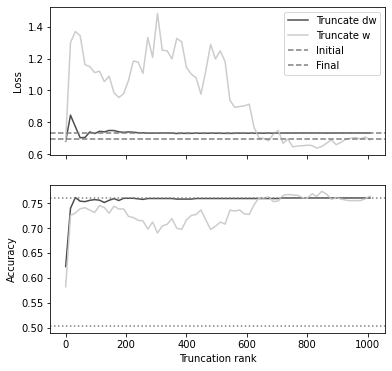

In [15]:
# Plot loss and accuracy over training epochs
fig = plt.figure(figsize=(6, 6), facecolor='w')
axes = fig.subplots(2, 1, sharex=True)
axes = axes[:, None]
epochs = np.arange(N_EPOCHS)
train_loss, valid_loss, train_acc, valid_acc = loss_acc.T

ax0, ax1 = axes[:, 0]

for j in range(2):
    # ls = ['-', '--'][j]
    ls = '-'
    lbl = ['Truncate dw', 'Truncate w'][j]
    # c = colors[0]
    c = ['0.3', '0.8'][j]

    trunc_loss, trunc_acc = trunc_loss_acc[j].T
    ax0.plot(trunc_ranks, trunc_loss, ls, c=c, label=lbl)
    ax1.plot(trunc_ranks, trunc_acc, ls, c=c, label=lbl)

# Initial and final loss and accuracy
c = '0.5'
ax0.axhline(valid_loss[0], ls='--', c=c, label='Initial')
ax1.axhline(valid_acc[0], ls=':', c=c, label='Initial')
ax0.axhline(valid_loss[-1], ls='--', c=c, label='Final')
ax1.axhline(valid_acc[-1], ls=':', c=c, label='Final')

ax0.legend()
# ax0.axhline(0, c='0.5', zorder=-1)
# ax1.axhline(0, c='0.5', zorder=-1)
ax0.set_ylabel('Loss')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Truncation rank")

plt.show(fig)
plt.close(fig)

In [16]:


# Save everything
state_dict_final = model.state_dict()
with open(SAVE, 'wb') as f:
    torch.save({'state_dict_init': state_dict_init,
                'state_dict_final': state_dict_final,
                'loss_acc': loss_acc,
                'trunc_loss_acc': trunc_loss_acc,
                'trunc_ranks': trunc_ranks,
                'svd_blockwise': svd_blockwise,
                }, f)
# print("Saved last model to '%s'" % SAVE)
print("Saved initial and final model to '%s'" % SAVE)

Saved initial and final model to 'saved_models/sst_lstm_nlayers_1_nhid_1024_emb_pretrained_fix_dim_100_dropout_00_weight_decay_0000_seed_4375.pt'
